In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn import metrics

In [2]:
NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'RHHBY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
4336


<AxesSubplot:xlabel='Date'>

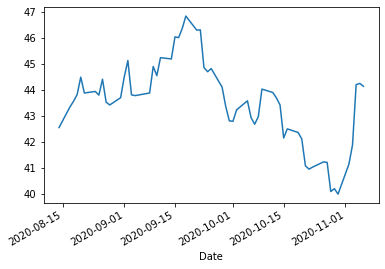

In [3]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(len(data))

tmp = data.iloc[-60:]
tmp['close'].plot()

<AxesSubplot:xlabel='Date'>

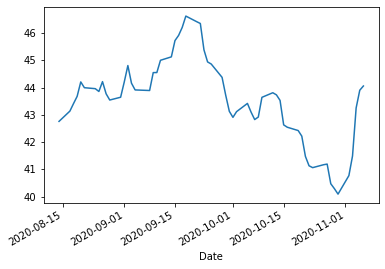

In [4]:


"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()



In [5]:


def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)



Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [6]:


live_pred_data = data.iloc[-16:-11]



In [7]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()
print(len(data))


4307


In [8]:
def _split_data(data):

    """
    Function to partition the data into the train and test set
    :return:
    """

    y = data['pred']
    features = [x for x in data.columns if x not in ['pred']]
    X = data[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 99 * len(X) // 100,shuffle=False)
    print(y_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = _split_data(data)
print('X Train : ' + str(len(X_train)))
print('X Test  : ' + str(len(X_test)))
print('y Train : ' + str(len(y_train)))
print('y Test  : ' + str(len(y_test)))

Date
2020-08-17    1.0
2020-08-18    1.0
2020-08-19    1.0
2020-08-20    1.0
2020-08-21    1.0
2020-08-24    1.0
2020-08-25    1.0
2020-08-26    1.0
2020-08-27    1.0
2020-08-28    1.0
2020-08-31    1.0
2020-09-01    1.0
2020-09-02    1.0
2020-09-03    1.0
2020-09-04    1.0
2020-09-08    0.0
2020-09-09    0.0
2020-09-10    0.0
2020-09-11    0.0
2020-09-14    0.0
2020-09-15    0.0
2020-09-16    0.0
2020-09-17    0.0
2020-09-18    0.0
2020-09-21    0.0
2020-09-22    0.0
2020-09-23    0.0
2020-09-24    0.0
2020-09-25    0.0
2020-09-28    0.0
2020-09-29    0.0
2020-09-30    0.0
2020-10-01    0.0
2020-10-02    0.0
2020-10-05    0.0
2020-10-06    0.0
2020-10-07    0.0
2020-10-08    0.0
2020-10-09    0.0
2020-10-12    0.0
2020-10-13    0.0
2020-10-14    0.0
2020-10-15    1.0
2020-10-16    1.0
Name: pred, dtype: float64
X Train : 4263
X Test  : 44
y Train : 4263
y Test  : 44


In [9]:

def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    #params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    #rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf.fit(X_train, y_train)
    
    # Save best model
    #rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    #print(rf_gs.best_params_)
    
    prediction = rf.predict(X_test)

#     print(classification_report(y_test, prediction))
#     print(confusion_matrix(y_test, prediction))
    
    return rf
    
#rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

In [10]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 10)}
    
    # Use gridsearch to test all values for n_neighbors
    #knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn.fit(X_train, y_train)
    
    # Save best model
    #knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    #print(knn_gs.best_params_)
    
#     prediction = knn.predict(X_test)

#     print(classification_report(y_test, prediction))
#     print(confusion_matrix(y_test, prediction))
    
    return knn
    
#knn_model = _train_KNN(X_train, y_train, X_test, y_test)

In [11]:


def _train_GBT(X_train, y_train, X_test, y_test):
    
    clf = GradientBoostingClassifier()
    
    # Dictionary of parameters to optimize
    #params_gbt = {'n_estimators' :[150,160,170,180] , 'learning_rate' :[0.2,0.1,0.09] }
    
    # Use gridsearch to test all values for n_neighbors
    #grid_search = GridSearchCV(clf, params_gbt, cv=5)
    
    # Fit model to training data
    clf.fit(X_train, y_train)
    
    #gbt_best = grid_search.best_estimator_
    
    # Save best model
    #print(grid_search.best_params_)
    
    prediction = clf.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    
    return clf


#gbt_model = _train_GBT(X_train, y_train, X_test, y_test)




In [12]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='soft')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
#ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

In [13]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
#         print('rf prediction is ', rf_prediction)
#         print('knn prediction is ', knn_prediction)
#         print('ensemble prediction is ', ensemble_prediction)
#         print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
    
cross_Validation(data)

1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[ 2  0]
 [ 0 10]]
0.6666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.6666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
            

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
1.0 0.0 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        10
         1.0       0.20      1.00      0.33         2

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 8]
 [0 2]]
0.3333333333333333 0.16666666666666666 0.3333333333333333
0.75
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.45      0.41      0.43        12
weighted avg       0.83      0.75      0.79        12

[[9 2]
 [1 0]]
0.08333333333333333 0.9166666666666666 0.75
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.0

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.25 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.4166666666666667 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.4166666666666667 0.5833333333333334 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[11  1]
 [ 0  0]]
0.25 1.0 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.5 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93         8
         1.0       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12

[[7 1]
 [0 4]]
0.8333333333333334 0.75 0.9166666666666666
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[11  1]
 [ 0  0]]
0.75 1.0 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
1.0 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
0.5833333333333334 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.88      0.88      0.88         8

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12

[[3 1]
 [1 7]]
0.8333333333333334 0.8333333333333334 0.8333333333333334
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25      

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.25 1.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
0.3333333333333333 0.3333333333333333 0.333333

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.16666666666666666 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00     

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.50      0.83      0.62         6
         1.0       0.50      0.17      0.25         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.44        12
weighted avg       0.50      0.50      0.44        12

[[5 1]
 [5 1]]
0.5833333333333334 0.5 0.5
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0 1.0
0.6666666666666666
 

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77         8
         1.0       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12

[[5 3]
 [0 4]]
0.8333333333333334 0.3333333333333333 0.75
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.9166666666666666 0.4166666666666667 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.6666666666666666 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.75 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.3333333333333333 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93         8
         1.0       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12

[[7 1]
 [0 4]]
0.6666666666666666 1.0 0.9166666666666666
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.9166666666666666 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.56      0.71         9
         1.0       0.43      1.00      0.60         3

    accuracy                           0.67        12
   macro avg       0.71      0.78      0.66        12
weighted avg       0.86      0.67      0.69        12

[[5 4]
 [0 3]]
0.6666666666666666 0.6666666666666666 0.6666666666666666
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.6666666666666666 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.6666666666666666 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         6
         1.0       0.60      1.00      0.75         6

    accuracy                           0.67        12
   macro avg       0.80      0.67      0.62        12
weighted avg       0.80      0.67      0.62        12

[[2 4]
 [0 6]]
0.9166666666666666 0.6666666666666666 0.6666666666666666
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71         6
         1.0       1.00      0.17      0.29         6

    accuracy                           0.58        12
   macro avg       0.77      0.58      0.50      

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67        12
   macro avg       0.40      0.40      0.40        12
weighted avg       0.67      0.67      0.67        12

[[8 2]
 [2 0]]
0.8333333333333334 0.5833333333333334 0.6666666666666666
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.64      0.88      0.74         8

    accuracy                           0.58        12
   macro avg       0.32      0.44      0.37        12
weighted avg       0.42      0.58      0.49        12

[[0 4]
 [1 7]]
0.6666666666666666 0.3333333333333333 0.5833333333333334
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00   

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.5833333333333334 1.0 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.916

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
0.16666666666666666 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.75 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         2
         1.0       0.00      0.00      0.00        10

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 2  0]
 [10  0]]
0.16666666666666666 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.43      0.50      0.46         6

    accuracy                           0.42        12
   macro avg       0.41      0.42      0.41        12
weighted avg       0.41      0.42      0.41        12

[[2 4]
 [3 3]]
0.3333333333333333 0.3333333333333333 0.4166666666666667
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.25 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.9166666666666666 1.0
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.6666666666666666 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.9166666666666666 1.0 1.0
0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[9 3]
 [0 0]]
0.0 0.9166666666666666 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.4166666666666667 1.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
0.3333333333333333 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.6666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.16666666666666666 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.41666666666

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.75 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
0.4166666666666667 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         3
         1.0       1.00      0.33      0.50         9

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 0]
 [6 3]]
0.5833333333333334 0.25 0.5
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.75 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.75 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.3333333333333333 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.8333333333333334 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
1.0 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.6666666666666666 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50        12

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[0 0]
 [8 4]]
0.4166666666666667 0.0 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.8333333333333334 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.50      0.40      0.44         5
         1.0       0.62      0.71      0.67         7

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12

[[2 3]
 [2 5]]
0.3333333333333333 0.6666666666666666 0.5833333333333334
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.08333333333333333 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.9166666666666666 1.0 1.0
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.5833333333333334 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.8333333333333334 0.0 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.9166666666666666 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.75 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.75 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         4
         1.0       0.73      1.00      0.84         8

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12

[[1 3]
 [0 8]]
0.25 0.75 0.75
0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[11  1]
 [ 0  0]]
0.6666666666666666 1.0 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.92

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.75 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.16666666666666666 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.00        11

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 1  0]
 [11  0]]
0.3333333333333333 0.5 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.25 1.0 1.0
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
0.5833333333333334 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
0.5 0.9166666666666666 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.6666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5 0.5833333333333334 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[9 3]
 [0 0]]
1.0 0.0 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67         5
         1.0       0.80      0.57      0.67         7

    accuracy                           0.67        12
   macro avg       0.69      0.69      0.67        12
weighted avg       0.70      0.67      0.67        12

[[4 1]
 [3 4]]
0.9166666666666666 0.75 0.6666666666666666
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]
0.8333333333333334 0.0 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.16666666666666666 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
0.75 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]
0.4166666666666667 0.5833333333333334 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.75 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.916666

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666 0.6666666

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.36      1.00      0.53         4

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[1 7]
 [0 4]]
0.5 0.3333333333333333 0.4166666666666667
0.16666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.09      0.17        11
         1.0       0.09      1.00      0.17         1

    accuracy                           0.17        12
   macro avg       0.55      0.55      0.17        12
weighted avg       0.92      0.17      0.17        12

[[ 1 10]
 [ 0  1]]
0.16666666666666666 0.9166666666666666 0.16666666666666666
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00 

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.91      0.95        11

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12

[[ 1  0]
 [ 1 10]]
0.5833333333333334 0.9166666666666666 0.9166666666666666
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[8 4]
 [0 0]]
0.6666666666666666 1.0 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
0.3333333333333333 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       1.00      0.10      0.18        10
         1.0       0.18      1.00      0.31         2

    accuracy                           0.25        12
   macro avg       0.59      0.55      0.24        12
weighted avg       0.86      0.25      0.20        12

[[1 9]
 [0 2]]
0.9166666666666666 0.25 0.25
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58    

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         9
         1.0       0.50      1.00      0.67         3

    accuracy                           0.75        12
   macro avg       0.75      0.83      0.73        12
weighted avg       0.88      0.75      0.77        12

[[6 3]
 [0 3]]
0.6666666666666666 0.25 0.75
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.75 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
0.75
           

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         2
         1.0       0.00      0.00      0.00        10

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 2  0]
 [10  0]]
0.3333333333333333 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.91      1.00      0.95        10

    accuracy                           0.92        12
   macro avg       0.95      0.75      0.81        12
weighted avg       0.92      0.92      0.90        12

[[ 1  1]
 [ 0 10]]
0.5 0.8333333333333334 0.9166666666666666
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.9166666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[ 2  0]
 [ 0 10]]
0.8333333333333334 0.16666666666666666 1.0
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.25 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.9166666666666666 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.3333333333333333 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.16666666666666666 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.90      0.82      0.86        11

    accuracy                           0.75        12
   macro avg       0.45      0.41      0.43        12
weighted avg       0.83      0.75      0.79        12

[[0 1]
 [2 9]]
0.25 0.9166666666666666 0.75
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.9166666666666666 1.0 1.0
0.5
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.5 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.75 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.3333333333333333 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.4166666666666667 0.0 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         9
         1.0       0.50      1.00      0.67         3

    accuracy                           0.75        12
   macro avg       0.75      0.83      0.73        12
weighted avg       0.88      0.75      0.77        12

[[6 3]
 [0 3]]
0.75 0.75 0.75
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.4166666666666667 0.0 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.16666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.0

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         2
         1.0       0.00      0.00      0.00        10

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 2  0]
 [10  0]]
0.16666666666666666 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.9166666666666666 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.9166666666666666 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67         5
         1.0       0.80      0.57      0.67         7

    accuracy                           0.67        12
   macro avg       0.69      0.69      0.67        12
weighted avg       0.70      0.67      0.67        12

[[4 1]
 [3 4]]
0.75 0.4166666666666667 0.6666666666666666
0.16666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.09      0.17        11
         1.0       0.09      1.00      0.17         1

    accuracy                           0.17        12
   macro avg       0.55      0.55      0.17        12
weighted avg       0.92      0.17      0.17        12

[[ 1 10]
 [ 0  1]]
0.4166666666666667 0.16666666666666666 0.16666666666666666
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         2
         1.0       1.00      0.80      0.89        10

    accuracy                           0.83        12
   macro avg       0.75      0.90      0.78        12
weighted avg       0.92      0.83      0.85        12

[[2 0]
 [2 8]]
0.9166666666666666 0.25 0.8333333333333334
0.5
              precision    recall  f1-score   support

         0.0       0.33      0.50      0.40         4
         1.0       0.67      0.50      0.57         8

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.56      0.50      0.51        12

[[2 2]
 [4 4]]
0.3333333333333333 0.6666666666666666 0.5
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy             

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
1.0 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.78      0.70      0.74        10

    accuracy                           0.58        12
   macro avg       0.39      0.35      0.37        12
weighted avg       0.65      0.58      0.61        12

[[0 2]
 [3 7]]
0.25 0.5833333333333334 0.5833333333333334
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.75 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.6666666666666666 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.27      1.00      0.43         3
         1.0       1.00      0.11      0.20         9

    accuracy                           0.33        12
   macro avg       0.64      0.56      0.31        12
weighted avg       0.82      0.33      0.26        12

[[3 0]
 [8 1]]
0.3333333333333333 0.25 0.3333333333333333
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.64      0.88      0.74         8

    accuracy                           0.58        12
   macro avg       0.32      0.44      0.37        12
weighted avg       0.42      0.58      0.49        12

[[0 4]
 [1 7]]
0.9166666666666666 0.6666666666666666 0.5833333333333334
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accura

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 2 10]
 [ 0  0]]
0.08333333333333333 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.4166666666666667 1.0 1.0
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.6666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 1 11]
 [ 0  0]]
0.3333333333333333 0.0 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5833333333333334 0.0 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.08333333333333333 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00    

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.8333333333333334 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
0.4166666666666667 0.9166666666666666 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.6666666666666666 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5 0.6666666666666666 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

[[5 1]
 [1 5]]
0.8333333333333334 0.5 0.8333333333333334
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.91      0.95        11

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12

[[ 1  0]
 [ 1 10]]
0.75 0.9166666666666666 0.9166666666666666
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    ac

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12

[[10  1]
 [ 0  1]]
1.0 0.08333333333333333 0.9166666666666666
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00        11

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[ 1  0]
 [ 0 11]]
1.0 0.8333333333333334 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75   

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.4166666666666667 1.0 1.0
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.5 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.3333333333333333 0.6666666666666666 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90         9
         1.0       1.00      0.33      0.50         3

    accuracy                           0.83        12
   macro avg       0.91      0.67      0.70        12
weighted avg       0.86      0.83      0.80        12

[[9 0]
 [2 1]]
0.75 0.8333333333333334 0.8333333333333334
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]
0.75 0.0 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.75 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84         8
         1.0       1.00      0.25      0.40         4

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12

[[8 0]
 [3 1]]
0.9166666666666666 0.6666666666666666 0.75
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.16666666666666666 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.11      1.00      0.20         1
         1.0       1.00      0.27      0.43        11

    accuracy                           0.33        12
   macro avg       0.56      0.64      0.31        12
weighte

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.33      0.50      0.40         4
         1.0       0.67      0.50      0.57         8

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.56      0.50      0.51        12

[[2 2]
 [4 4]]
0.6666666666666666 0.3333333333333333 0.5
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.08333333333333333 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.6666666666666666 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.29      0.50      0.36         4
         1.0       0.60      0.38      0.46         8

    accuracy                           0.42        12
   macro avg       0.44      0.44      0.41        12
weighted avg       0.50      0.42      0.43        12

[[2 2]
 [5 3]]
0.3333333333333333 0.75 0.4166666666666667
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.6666666666666666 0.9166666666666666 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.62         9
         1.0       0.38      1.00      0.55         3

    accuracy                           0.58        12
   macro avg       0.69      0.72      0.58        12
weighted avg       0.84      0.58      0.60        12

[[4 5]
 [0 3]]
0.25 0.8333333333333334 0.5833333333333334
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.4166666666666667 0.25 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[9 3]
 [0 0]]
0.3333333333333333 1.0 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
0.3333333333333333 0.3333333333333333 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.4166666666666667 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.75 1.0 1.0
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
0.16666666666666666 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         8
         1.0       0.40      1.00      0.57         4

    accuracy                           0.50        12
   macro avg       0.70      0.62      0.49        12
weighted avg       0.80      0.50      0.46        12

[[2 6]
 [0 4]]
0.5833333333333334 0.3333333333333333 0.5
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
1.0 0.0 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.0 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.8333333333333334 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 0.9166666666666666 1.0
0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.38      0.55         8
         1.0       0.44      1.00      0.62         4

    accuracy                           0.58        12
   macro avg       0.72      0.69      0.58        12
weighted avg       0.81      0.58      0.57        12

[[3 5]
 [0 4]]
1.0 0.5833333333333334 0.5833333333333334
0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         3
         1.0       1.00      0.33      0.50         9

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 0]
 [6 3]]
0.9166666666666666 0.25 0.5
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.5833333333333334 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.4166666666666667 0.9166666666666666 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[6 6]
 [0 0]]
0.16666666666666666 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.8333333333333334 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.25 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00   

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.00        11

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 1  0]
 [11  0]]
0.08333333333333333 0.08333333333333333 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.16666666666666666 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5 0.8333333333333334 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.16666666666666666 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.9166666666666666 1.0 1.0
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         2
         1.0       0.00      0.00      0.00        10

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 2  0]
 [10  0]]
0.16666666666666666 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12

[[10  1]
 [ 0  1]]
0.8333333333333334 0.5833333333333334 0.9166666666666666
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12

[[10  1]
 [ 0  1]]
0.6666666666666666 0.75 0.9166666666666666
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.3333333333333333 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.6666666666666666 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         6
         1.0       1.00      0.50      0.67         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12

[[6 0]
 [3 3]]
0.5833333333333334 0.5 0.75
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.91      1.00      0.95        10

    accuracy                           0.92        12
   macro avg       0.95      0.75      0.81        12
weighted avg       0.92      0.92      0.90        12

[[ 1  1]
 [ 0 10]]
1.0 0.8333333333333334 0.9166666666666666
0.08333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                      

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.6666666666666666 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.9166666666666666 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         6
         1.0       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[6 0]
 [6 0]]
0.8333333333333334 0.5 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78         7
         1.0       1.00      0.20      0.33         5

    accuracy                           0.67        12
   macro avg       0.82      0.60      0.56        12
weighted avg       0.79      0.67      0.59        12

[[7 0]
 [4 1]]
0.75 0.5833333333333334 0.6666666666666666
0.75
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         3
         1.0       1.00      0.67      0.80         9

    accuracy                           0.75        12
   macro avg       0.75      0.83      0.73        12
weighted avg       0.88

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 1.0 1.0
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.3333333333333333 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.5833333333333334 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5 1.0 0.5


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.6666666666666666 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00     

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.82      1.00      0.90         9

    accuracy                           0.83        12
   macro avg       0.91      0.67      0.70        12
weighted avg       0.86      0.83      0.80        12

[[1 2]
 [0 9]]
0.75 0.75 0.8333333333333334
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
0.5833333333333334 0.5 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.25 1.0 1.0
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.4166666666666667 0.3333333333333333 0.333333

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84        11
         1.0       0.25      1.00      0.40         1

    accuracy                           0.75        12
   macro avg       0.62      0.86      0.62        12
weighted avg       0.94      0.75      0.81        12

[[8 3]
 [0 1]]
0.6666666666666666 1.0 0.75
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.16666666666666666 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.64      1.00      0.78         7

    accuracy                           0.67        12
   macro avg       0.82      0.60      0.56        12
weighted avg       0.79      0.67      0.59        12

[[1 4]
 [0 7]]
0.75 0.5833333333333334 0.6666666666666666
0.3333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]
0.9166666666666666 0.0 0.3333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.6666666666666666 1.0 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       1.00      0.30      0.46        10
         1.0       0.22      1.00      0.36         2

    accuracy                           0.42        12
   macro avg       0.61      0.65      0.41        12
weighted avg       0.87      0.42      0.45        12

[[3 7]
 [0 2]]
0.5833333333333334 0.16666666666666666 0.4166666666666667
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5833333333333334 1.0 1.0
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.5833333333333334 0.4166666666666667 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.5 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[9 3]
 [0 0]]
0.16666666666666666 1.0 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]
0.5 0.0 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.0 1.0
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.8333333333333334 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.16666666666666666 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00   

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.29      1.00      0.44         2
         1.0       1.00      0.50      0.67        10

    accuracy                           0.58        12
   macro avg       0.64      0.75      0.56        12
weighted avg       0.88      0.58      0.63        12

[[2 0]
 [5 5]]
0.8333333333333334 0.16666666666666666 0.5833333333333334
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.75 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.12      1.00      0.22         1
         1.0       1.00      0.36      0.53        11

    accuracy                           0.42        12
   macro avg       0.56      0.68      0.38        12
weighted avg       0.93      0.42      0.51        12

[[1 0]
 [7 4]]
0.6666666666666666 0.16666666666666666 0.4166666666666667
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57         5
         1.0       0.70      1.00      0.82         7

    accuracy                           0.75        12
   macro avg       0.85      0.70      0.70        12
weighted avg       0.82      0.75      0.72        12

[[2 3]
 [0 7]]
0.75 0.6666666666666666 0.75
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.08333333333333333 1.0 1.0
1.0
            

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[10  0]
 [ 0  2]]
1.0 0.8333333333333334 1.0
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.17      1.00      0.29         2
         1.0       0.00      0.00      0.00        10

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 2  0]
 [10  0]]
0.8333333333333334 0.16666666666666666 0.16666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 1.0 1.0
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667 0.4166666666666667 0.4166666666666667


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]
0.25 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
0.16666666666666666 0.16666

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.9166666666666666 0.75 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.08333333333333333 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
1.0 0.5833333333333334 0.5833333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90         9
         1.0       1.00      0.33      0.50         3

    accuracy                           0.83        12
   macro avg       0.91      0.67      0.70        12
weighted avg       0.86      0.83      0.80        12

[[9 0]
 [2 1]]
0.8333333333333334 0.75 0.8333333333333334
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]
1.0 0.0 0.75


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.3333333333333333 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 1.0 1.0
1.0
              precision    recall  f1-score   support

         1.0       1.00

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5 1.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77         5
         1.0       1.00      0.57      0.73         7

    accuracy                           0.75        12
   macro avg       0.81      0.79      0.75        12
weighted avg       0.84      0.75      0.74        12

[[5 0]
 [3 4]]
0.4166666666666667 0.75 0.75
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92    

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.75 1.0 1.0
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666 0.9166666666666666 0.9166666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.25 0.25 0.25


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[8 0]
 [4 0]]
0.6666666666666666 0.6666666666666666 0.6666666666666666


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0 0.0 1.0
0.75
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         4
         1.0       0.73      1.00      0.84         8

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12

[[1 3]
 [0 8]]
0.8333333333333334 0.6666666666666666 0.75
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34

/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 1 11]
 [ 0  0]]
0.5 0.0 0.08333333333333333


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80         5
         1.0       0.86      0.86      0.86         7

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

[[4 1]
 [1 6]]
0.8333333333333334 0.4166666666666667 0.8333333333333334
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.6666666666666666 0.75 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.5833333333333334 0.8333333333333334 0.8333333333333334


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0 0.0 0.0


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]
0.4166666666666667 0.25 0.3333333333333333
RF Accuracy = 0.6325136612021859
KNN Accuracy = 0.6288056206088993
Ensemble Accuracy = 0.6727166276346604


/home/aschonn/anaconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Before we produced the prediction data, we grabbed this small dataframe to use in actual testing
live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2020-10-16,42.546445,35.931494,-0.421379,-0.316985,7.217393,-1.135360e+09,0.551725,-0.571065,34.692871,-1.350411,9.260328e+07,-94.761000,-0.056380,1.075996,0.732514,0.973190,0.968329,0.970951,0.982464,0.807153
2020-10-19,42.425256,34.971831,-0.463995,-0.346387,6.028451,-1.135818e+09,0.541628,-0.992874,36.803774,-1.126455,9.197361e+07,-98.084460,-0.042697,1.030478,0.802123,0.970981,0.967084,0.970243,0.982997,0.817204
2020-10-20,42.220340,33.349889,-0.508443,-0.378798,2.292818,-1.136301e+09,0.520916,-0.880506,38.375603,-2.080757,9.141061e+07,-115.737691,-0.036013,1.034217,0.862401,0.966930,0.964060,0.967779,0.981808,0.765015
2020-10-21,41.479120,28.246711,-0.596601,-0.422359,0.585257,-1.137245e+09,0.539709,-1.348176,38.915971,-4.465899,9.042485e+07,-174.972582,-0.055839,1.057027,0.815040,0.950888,0.949417,0.953919,0.970301,1.267742
2020-10-22,41.135193,26.240301,-0.686307,-0.475149,4.372562,-1.137758e+09,0.533287,-1.784862,30.381227,-4.560591,8.946799e+07,-205.340543,-0.074864,1.143699,0.753420,0.944058,0.944053,0.949426,0.968347,1.185036
